In [1]:
import pandas as pd
import numpy as np
import sys
import os.path
import pickle
import time
import re
import sklearn_pandas
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Load
Read the file resulting from the scraping:

In [2]:
# Location of the dataframe pickle file containing all the boat data:
boats_df_path = './data/boats_df.pkl'
if os.path.isfile(boats_df_path):
    df = pd.read_pickle(boats_df_path)
    print(len(df),' boats read from file into boats_df.')

3001  boats read from file into boats_df.


In [56]:
df.head()

,price_str,make,model,year_str,cls,length_ft,LOA_ft,displacement_lb,fuel_type,power_hp,eng_make,eng_model,eng_year,eng_hrs,location,year,price_USD
5637501,Request Price,Bali,4.5,2020,Catamaran,45,45 ft,32800,Diesel,50,None,None,2016,50,"All Locations, California",2020,NaN
7213466,89500,Beneteau,OC 400,1996,Sloop,40,40 ft,19200,Diesel,None,Perkins,M-50,None,None,"Kenosha , Wisconsin",1996,89500.0
7216014,125900,Hunter,466,2002,Cruiser (Sail),46,46 ft 1 in,26180,Diesel,76,Yanmar,None,2002,938,"Stamford, Connecticut",2002,125900.0
7191853,265000,Jeanneau,Sun Odyssey 419,2018,Cruiser (Sail),42,41 ft 10 in,None,Diesel,45,Yanmar,None,None,300,"Portsmouth, Rhode Island",2018,265000.0
7152732,388900,Fountaine Pajot,Orana 44,2012,Multi-Hull,44,44 ft,None,Diesel,None,Volvo Penta,D2-40,2012,5270,"St Thomas, United States",2012,388900.0


I'm going to rename the feature 'year' to 'year_str'

In [3]:
df.rename(columns={'year':'year_str'},inplace=True)
df.rename(columns={'price':'price_str'},inplace=True)

# Clean
Clean steps to prepare the data for modeling:

In [59]:
# There are no null values in the year so it simply be converted to an int:
df['year'] = df['year_str'].astype(int)
df['length_ft'] = df['length_ft'].astype(int)
df.describe()

,length_ft,year,price_USD
count,3000.000000,3000.00000,2.911000e+03
mean,44.269000,2001.94800,1.811504e+05
std,2.980313,13.74718,1.276372e+05
min,40.000000,1860.00000,9.760000e+03
25%,42.000000,1996.00000,9.570000e+04
50%,44.000000,2005.00000,1.430000e+05
75%,46.000000,2011.00000,2.210000e+05
max,50.000000,2020.00000,1.350000e+06


$ \def\euro{\unicode{x20AC}} $
$ \def\yen{\unicode{x00A5}}  $
$ \def\pound{\unicode{x00A3}} $
$ \def\dollar{\unicode{x024}} $  
$euro = \euro$ is asci 8364  
$pound = \pound$ is ascii 163

In [5]:
print('euro = ',chr(8364))
print('pound = ',chr(163))

euro =  €
pound =  £


In [6]:
def Currency_Converter(row):
    """
    Coverts dataframe series values named 'price_str' to US$
    using converstion rates on 10/8/2019
    """

    first_price_char = row.price_str.strip()[0]
    if row.price_str == 'Request Price':  # New Boat
        return None
    price = float(re.search('\d+', row.price_str).group(0))
    if re.match(r'\d',first_price_char):  # US$
        return price
    if first_price_char == chr(8364):  # Euro
        return price * 1.10
    if first_price_char == chr(163):  # British Pound
        return price * 1.22
    if first_price_char == 'A':   # Austrialian $
        return price * 0.67
    if row.price_str[:2] == 'CA':
        return price * 0.75
    if row.price_str[:2] == 'NZ':
        return price * 0.63
    if row.price_str[:3] == 'Dkr':
        return price * 0.15
    return None

# Prices had 'US$' stripped but for other denominations there are still symbol characters:
# Convert all price strings to US$ using Currency_Converter above
df['price_USD'] = df.apply(Currency_Converter,axis=1).copy()
df.price_USD.describe()

count    2.912000e+03
mean     1.821184e+05
std      1.378925e+05
min      9.760000e+03
25%      9.570000e+04
50%      1.430000e+05
75%      2.220500e+05
max      3.000000e+06
Name: price_USD, dtype: float64

In [44]:
# I'm going to drop the 1 value that is an order of magnitude above the others.
df.drop(df.price_USD.idxmax(), inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 5637501 to 1015053
Data columns (total 17 columns):
price_str          3000 non-null object
make               3000 non-null object
model              2947 non-null object
year_str           3000 non-null object
cls                3000 non-null object
length_ft          3000 non-null object
LOA_ft             2708 non-null object
displacement_lb    1466 non-null object
fuel_type          2892 non-null object
power_hp           2086 non-null object
eng_make           2170 non-null object
eng_model          1587 non-null object
eng_year           1369 non-null object
eng_hrs            1118 non-null object
location           3000 non-null object
year               3000 non-null int64
price_USD          2911 non-null float64
dtypes: float64(1), int64(1), object(15)
memory usage: 421.9+ KB


Grab the parts of df that will be modeled and eliminate rows that have None's.

In [60]:
data = df.loc[:,['year','price_USD','length_ft']].copy()
data.dropna(inplace=True)
X = data[['year', 'length_ft']]
y = data['price_USD']

In [63]:
# Divide the data into test and train sets:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=.2, random_state=42)

In [64]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
#posTransform = make_pipeline(FunctionTransformer(np.log), StandardScaler())
    # (['Lot Area', 'Gr Liv Area'], posTransform),
mapper = DataFrameMapper([
        (['year', 'length_ft'], StandardScaler())
        ])

pipe = make_pipeline(mapper, LinearRegression())

In [65]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['year', 'length_ft'],
                                            StandardScaler(copy=True,
                                                           with_mean=True,
                                                           with_std=True))],
                                 input_df=False, sparse=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [66]:
r2_train = pipe.score(pd.DataFrame(X_train),y_train)
y_pred_test = np.exp(pipe.predict(X_test))
y_pred_train = np.exp(pipe.predict(X_train))
r2_test = pipe.score(X_test,y_test)

R2 Train:  0.35936773442495773
R2 Test:  0.3514006474273259


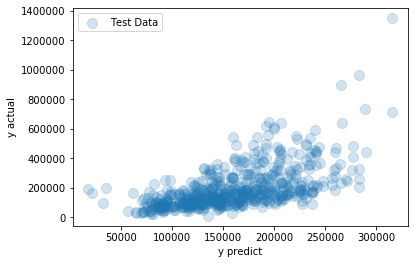

In [67]:
#Plot the results
fig,ax = plt.subplots(1,1);
ax.scatter(y_pred_test,np.exp(y_test),label='Test Data', s=100, alpha=0.2)
#ax.scatter(y_pred_train,np.exp(y_train),label='Train Data', s=100, alpha=0.2)
ax.set_ylabel('y actual')
ax.set_xlabel('y predict')
ax.legend();
print('R2 Train: ', r2_train)
print('R2 Test: ', r2_test)

This was the MVP linear regression.

In [ ]:
# Divide the data into test and train sets:
#X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=.2, random_state=42)
# Create an empty model
#lr = LinearRegression()

# Fit the model to the full dataset
#fit = lr.fit(pd.DataFrame(X_train), y_train)

# Calculate R2 for the training set
#y_pred_train = fit.predict(pd.DataFrame(X_train))
#r2_train = fit.score(pd.DataFrame(X_train),y_train)

# Calculate y_pred and R2 for the test set
#y_pred = fit.predict(pd.DataFrame(X_test))
#r2_test = fit.score(pd.DataFrame(X_test),y_test)
